In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import timeit

In [2]:
# datasets
dirty_train1 = pd.read_csv("./data/dirty_acm_train.tsv", sep="\t")
dirty_train2 = pd.read_csv("./data/dirty_scholar_train.tsv", sep="\t")
dirty_train3 = pd.read_csv("./data/dirty_amazon_train.tsv", sep="\t")
dirty_train4 = pd.read_csv("./data/dirty_walmart_train.tsv", sep="\t")
clean_train1 = pd.read_csv("./data/clean_acm_train.tsv", sep="\t")
clean_train2 = pd.read_csv("./data/clean_scholar_train.tsv", sep="\t")
clean_train3 = pd.read_csv("./data/clean_amazon_train.tsv", sep="\t")
clean_train4 = pd.read_csv("./data/clean_walmart_train.tsv", sep="\t")
dirty_test1 = pd.read_csv("./data/dirty_acm_test.tsv", sep="\t")
dirty_test2 = pd.read_csv("./data/dirty_scholar_test.tsv", sep="\t")
dirty_test3 = pd.read_csv("./data/dirty_amazon_test.tsv", sep="\t")
dirty_test4 = pd.read_csv("./data/dirty_walmart_test.tsv", sep="\t")
clean_test1 = pd.read_csv("./data/clean_acm_test.tsv", sep="\t")
clean_test2 = pd.read_csv("./data/clean_scholar_test.tsv", sep="\t")
clean_test3 = pd.read_csv("./data/clean_amazon_test.tsv", sep="\t")
clean_test4 = pd.read_csv("./data/clean_walmart_test.tsv", sep="\t")

In [3]:
# character based
def charDistance(s1,s2):
    # get the length of the strings
    m = len(s1)
    n = len(s2)
    # if some of them are empty, return the longer length of them
    if (m==0|n==0):
        return max(m,n)
    # create an empty matrix to store the calculation result
    A = np.zeros((m+1,n+1))
    # initialize the first row and column
    for i in range(0,m+1):
        A[i][0]=i
    for j in range(1,n+1):
        A[0][j]=j
    # calculate the distance column by column
    for j in range(1,n+1):
        for i in range(1,m+1):
            if (s1[i-1]==s2[j-1]):
                d=0
            else: d=1
            A[i][j]=min(A[i-1][j]+1,A[i][j-1]+1,A[i-1][j-1]+d)
    # return the final result
    return A[m][n]/max(m,n)

def prediction(dist_list, threshold):
    pre_list = [0]*len(dist_list)
    for i in range(len(dist_list)):
        if dist_list[i]<threshold:
            pre_list[i] = 1
    return pre_list

def getDistanceChar(list_text1, list_text2):
    dist = []
    if len(list_text1)!=len(list_text2):
        return("error")
    n = len(list_text1)
    for i in range(n):
        d = charDistance(list_text1[i],list_text2[i])
        dist.append(d)
    return dist

def toInt(list):
    result = []
    for i in range(len(list)):
        b = int(list[i])
        result.append(b)
    return result

def max_threshold(dist, real):
    max_f = 0
    max_t = 0
    threshold_list = np.linspace(0,1,101)
    for i in range(len(threshold_list)):
        pre_list = prediction(dist, threshold_list[i])
        pre = toInt(pre_list)
        f = f1_score(real, pre, average='binary')
        if f>max_f:
            max_f = f
            max_t = threshold_list[i]
    return max_t, max_f

def toStr(list):
    result = []
    for i in range(len(list)):
        a = str(list[i])
        result.append(a)
    return result

In [4]:
# crossparsing
def cp(C,D):
    cend=[]
    a=-1
    b=-1
    m=-1
    n=-1
    target=-1
    if C==''or D=='':
        s=1   
    else:
        for i in range(len(C)):
            t=1
            for j in range(len(D)):
                if C[i]== D[j]:
                    a=i
                    b=j
                    m=a
                    n=b
                while m < len(C) and n<len(D) and C[a:m+1]==D[b:n+1]:
                    m=m+1
                    n=n+1
                long=m-a
                if long >= t:
                    t = long
                    target = m
            
            x=target-1
            y=n-1
            if b <len(D) and C[i]==D[b] :
                cend.append(x)
            else:
                cend.append(i)
        s_AB = len(set(cend))
        z = C.find(D);
        if z!=-1:
            ss=s_AB-1;
        else:
            ss = s_AB
        s=ss/len(C)    
    return s

def distCPD(C,D):
    s1 = cp(C,D);
    s2 = cp(D,C);
    dist = 0.5*(s1+s2);
    return dist

def getDistanceCross(list_text1, list_text2):
    dist = []
    if len(list_text1)!=len(list_text2):
        return("error")
    n = len(list_text1)
    for i in range(n):
        d = distCPD(list_text1[i],list_text2[i])
        dist.append(d)
    return dist

In [5]:
# token based
def withStar(string):
    if string=='':
        return ''
    else:
        string = string.replace(" ", "**")
        return '**'+string[:]+'**'
    
def grams(string,num)->list[str]:
    string=withStar(string)
    begin=len(string)-num;
    token=[];
    for i in range(begin+1):
        a=[];
        a=string[i:i+3]
        token.append(a);
    return token;

def overlap(string1,string2)->int:
    s1=grams(string1,3);
    s2=grams(string2,3);
    common_elements = list(set(s1).intersection(set(s2)));
    lc=len(common_elements);
    m=min(len(s1),len(s2));
    if m==0: 
        return 0;
    else:
        sim1=lc/m;
        return sim1;
    
def jaccard(string1,string2):
    s1=grams(string1,3);
    s2=grams(string2,3);
    common_elements = list(set(s1).intersection(set(s2)));
    lc=len(common_elements);
    union_elements=list(set(s1).union(set(s2)));
    lu=len(union_elements);
    if lu==0:
        return 0;
    else:
        sim2 = lc/lu;
        return sim2;
    
def dice(string1,string2):
    s1=grams(string1,3);
    s2=grams(string2,3);
    common_elements = list(set(s1).intersection(set(s2)));
    lc=len(common_elements);
    if len(s1)+len(s2)==0:
        return 0;
    else:
        sim3=2*lc/(len(s1)+len(s2));
        return sim3;
    
def accuracy(mark_real,mark_test):
    sum = 0
    for i in range(len(mark_real)):
        if mark_real[i]==mark_test[i]:
            sum=sum+1
        else:
            continue
    return sum/len(mark_test)

def getCoeffOverlap(list_text1, list_text2):
    coeff = []
    if len(list_text1)!=len(list_text2):
        return("error")
    n = len(list_text1)
    for i in range(n):
        c = overlap(list_text1[i],list_text2[i])
        coeff.append(c)
    return coeff

def getCoeffJaccard(list_text1, list_text2):
    coeff = []
    if len(list_text1)!=len(list_text2):
        return("error")
    n = len(list_text1)
    for i in range(n):
        c = jaccard(list_text1[i],list_text2[i])
        coeff.append(c)
    return coeff

def getCoeffDice(list_text1, list_text2):
    coeff = []
    if len(list_text1)!=len(list_text2):
        return("error")
    n = len(list_text1)
    for i in range(n):
        c = dice(list_text1[i],list_text2[i])
        coeff.append(c)
    return coeff

def token_prediction(coeff_list, threshold):
    pre_list = [0]*len(coeff_list)
    for i in range(len(coeff_list)):
        if coeff_list[i]>threshold:
            pre_list[i] = 1
    return pre_list

def token_threshold(coeff, real):
    max_f = 0
    max_t = 0
    threshold_list = np.linspace(0,1,101)
    for i in range(len(threshold_list)):
        pre_list = token_prediction(coeff, threshold_list[i])
        pre = toInt(pre_list)
        f = f1_score(real, pre, average='binary')
        if f>max_f:
            max_f = f
            max_t = threshold_list[i]
    return max_t, max_f

## dblp acm

### character based

dblp acm clean character based method
threshold of the training set is:0.49
f1 score of training set is:0.8790035587188612
f1 score of the testing set is:0.8759124087591241
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      2029
           1       0.82      0.95      0.88       444

    accuracy                           0.95      2473
   macro avg       0.90      0.95      0.92      2473
weighted avg       0.96      0.95      0.95      2473

[[1934   95]
 [  24  420]]
3min 26s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


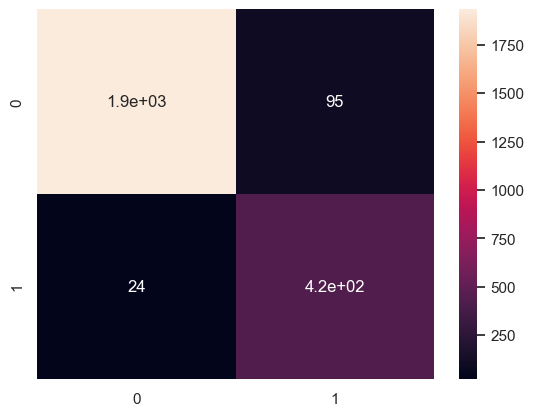

In [6]:
%%timeit -r 1 -n 1
# dblp acm clean character based
dist_train_char_1_1 = getDistanceChar(clean_train1['text_left'], clean_train1['text_right'])
real_train1_1 = toInt(clean_train1['label'])
t_train_char_1_1, f_train_char_1_1 = max_threshold(dist_train_char_1_1, real_train1_1)
print('dblp acm clean character based method')
print('threshold of the training set is:{}'.format(t_train_char_1_1))
print('f1 score of training set is:{}'.format(f_train_char_1_1))
dist_test_char_1_1 = getDistanceChar(clean_test1['text_left'], clean_test1['text_right'])
real_test1_1 = toInt(clean_test1['label'])
pre_list_char_1_1 = prediction(dist_test_char_1_1, t_train_char_1_1)
pre_char_1_1 = toInt(pre_list_char_1_1)
f_test_char_1_1 = f1_score(real_test1_1, pre_char_1_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_char_1_1))
print(classification_report(real_test1_1, pre_char_1_1))
sns.set()
C2= confusion_matrix(real_test1_1, pre_list_char_1_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)

dblp acm dirty character based method
threshold of the training set is:0.51
f1 score of training set is:0.8771670970121725
f1 score of the testing set is:0.8540540540540541
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2029
           1       0.82      0.89      0.85       444

    accuracy                           0.95      2473
   macro avg       0.90      0.92      0.91      2473
weighted avg       0.95      0.95      0.95      2473

[[1943   86]
 [  49  395]]
3min 27s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


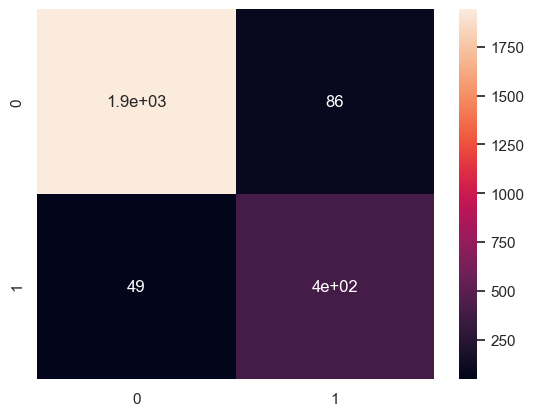

In [7]:
%%timeit -r 1 -n 1
# dblp acm dirty character based
dist_train_char_1_1 = getDistanceChar(dirty_train1['text_left'], dirty_train1['text_right'])
real_train1_1 = toInt(dirty_train1['label'])
t_train_char_1_1, f_train_char_1_1 = max_threshold(dist_train_char_1_1, real_train1_1)
print('dblp acm dirty character based method')
print('threshold of the training set is:{}'.format(t_train_char_1_1))
print('f1 score of training set is:{}'.format(f_train_char_1_1))
dist_test_char_1_1 = getDistanceChar(dirty_test1['text_left'], dirty_test1['text_right'])
real_test1_1 = toInt(dirty_test1['label'])
pre_list_char_1_1 = prediction(dist_test_char_1_1, t_train_char_1_1)
pre_char_1_1 = toInt(pre_list_char_1_1)
f_test_char_1_1 = f1_score(real_test1_1, pre_char_1_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_char_1_1))
print(classification_report(real_test1_1, pre_char_1_1))
sns.set()
C2= confusion_matrix(real_test1_1, pre_list_char_1_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)

### crossparsing

dblp acm clean character crossparsing
threshold of the training set is:0.23
f1 score of training set is:0.9303519061583578
f1 score of the testing set is:0.9218921892189219
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2029
           1       0.90      0.94      0.92       444

    accuracy                           0.97      2473
   macro avg       0.94      0.96      0.95      2473
weighted avg       0.97      0.97      0.97      2473

[[1983   46]
 [  25  419]]
2min 47s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


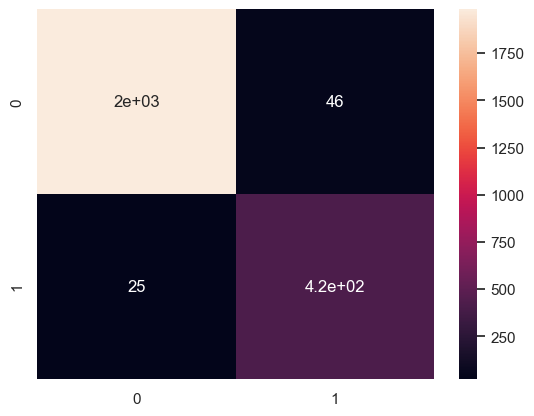

In [8]:
%%timeit -r 1 -n 1
# dblp acm clean crossparsing
dist_train_cross_1_1 = getDistanceCross(clean_train1['text_left'], clean_train1['text_right'])
real_train1_1 = toInt(clean_train1['label'])
t_train_cross_1_1, f_train_cross_1_1 = max_threshold(dist_train_cross_1_1, real_train1_1)
print('dblp acm clean character crossparsing')
print('threshold of the training set is:{}'.format(t_train_cross_1_1))
print('f1 score of training set is:{}'.format(f_train_cross_1_1))
dist_test_cross_1_1 = getDistanceCross(clean_test1['text_left'], clean_test1['text_right'])
real_test1_1 = toInt(clean_test1['label'])
pre_list_cross_1_1 = prediction(dist_test_cross_1_1, t_train_cross_1_1)
pre_cross_1_1 = toInt(pre_list_cross_1_1)
f_test_cross_1_1 = f1_score(real_test1_1, pre_cross_1_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_cross_1_1))
print(classification_report(real_test1_1, pre_cross_1_1))
sns.set()
C2= confusion_matrix(real_test1_1, pre_list_cross_1_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)

dblp acm dirty character crossparsing
threshold of the training set is:0.25
f1 score of training set is:0.9346879535558781
f1 score of the testing set is:0.9270946681175191
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2029
           1       0.90      0.96      0.93       444

    accuracy                           0.97      2473
   macro avg       0.94      0.97      0.96      2473
weighted avg       0.97      0.97      0.97      2473

[[1980   49]
 [  18  426]]
2min 46s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


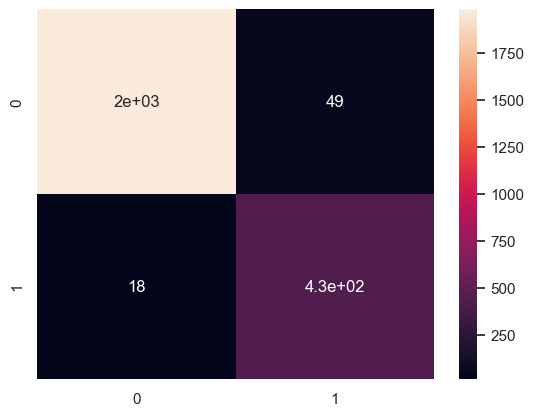

In [9]:
%%timeit -r 1 -n 1
# dblp acm dirty crossparsing
dist_train_cross_1_1 = getDistanceCross(dirty_train1['text_left'], dirty_train1['text_right'])
real_train1_1 = toInt(dirty_train1['label'])
t_train_cross_1_1, f_train_cross_1_1 = max_threshold(dist_train_cross_1_1, real_train1_1)
print('dblp acm dirty character crossparsing')
print('threshold of the training set is:{}'.format(t_train_cross_1_1))
print('f1 score of training set is:{}'.format(f_train_cross_1_1))
dist_test_cross_1_1 = getDistanceCross(dirty_test1['text_left'], dirty_test1['text_right'])
real_test1_1 = toInt(dirty_test1['label'])
pre_list_cross_1_1 = prediction(dist_test_cross_1_1, t_train_cross_1_1)
pre_cross_1_1 = toInt(pre_list_cross_1_1)
f_test_cross_1_1 = f1_score(real_test1_1, pre_cross_1_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_cross_1_1))
print(classification_report(real_test1_1, pre_cross_1_1))
sns.set()
C2= confusion_matrix(real_test1_1, pre_list_cross_1_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)

### token based

dblp acm clean overlap
threshold of the training set is:0.7000000000000001
f1 score of training set is:0.8923512747875354
f1 score of the testing set is:0.8881922675026123
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      2029
           1       0.83      0.96      0.89       444

    accuracy                           0.96      2473
   macro avg       0.91      0.96      0.93      2473
weighted avg       0.96      0.96      0.96      2473

[[1941   88]
 [  19  425]]
1.68 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


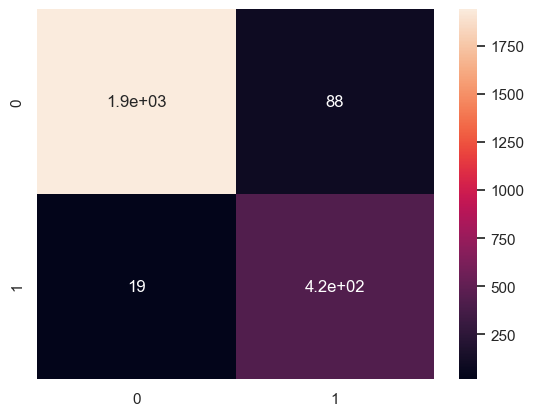

In [10]:
%%timeit -r 1 -n 1
# dblp acm clean overlap
coeff_train_overlap_1_1 = getCoeffOverlap(clean_train1['text_left'], clean_train1['text_right'])
real_train1_1 = toInt(clean_train1['label'])
t_train_overlap_1_1, f_train_overlap_1_1 = token_threshold(coeff_train_overlap_1_1, real_train1_1)
print('dblp acm clean overlap')
print('threshold of the training set is:{}'.format(t_train_overlap_1_1))
print('f1 score of training set is:{}'.format(f_train_overlap_1_1))
coeff_test_overlap_1_1 = getCoeffOverlap(clean_test1['text_left'], clean_test1['text_right'])
real_test1_1 = toInt(clean_test1['label'])
pre_list_overlap_1_1 = token_prediction(coeff_test_overlap_1_1, t_train_overlap_1_1)
pre_overlap_1_1 = toInt(pre_list_overlap_1_1)
f_test_overlap_1_1 = f1_score(real_test1_1, pre_overlap_1_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_overlap_1_1))
print(classification_report(real_test1_1, pre_overlap_1_1))
sns.set()
C2= confusion_matrix(real_test1_1, pre_list_overlap_1_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)

dblp acm dirty overlap
threshold of the training set is:0.7000000000000001
f1 score of training set is:0.8877840909090909
f1 score of the testing set is:0.884453781512605
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      2029
           1       0.83      0.95      0.88       444

    accuracy                           0.96      2473
   macro avg       0.91      0.95      0.93      2473
weighted avg       0.96      0.96      0.96      2473

[[1942   87]
 [  23  421]]
1.69 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


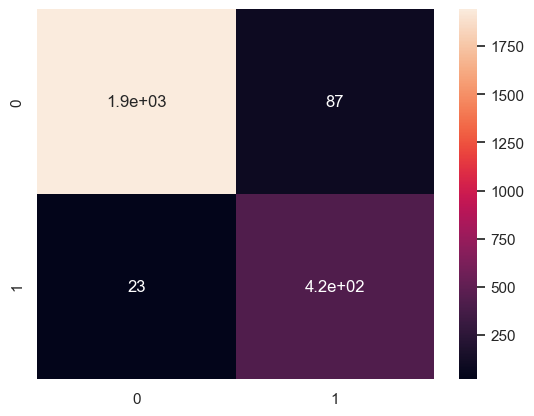

In [11]:
%%timeit -r 1 -n 1
# dblp acm dirty overlap
coeff_train_overlap_1_1 = getCoeffOverlap(dirty_train1['text_left'], dirty_train1['text_right'])
real_train1_1 = toInt(dirty_train1['label'])
t_train_overlap_1_1, f_train_overlap_1_1 = token_threshold(coeff_train_overlap_1_1, real_train1_1)
print('dblp acm dirty overlap')
print('threshold of the training set is:{}'.format(t_train_overlap_1_1))
print('f1 score of training set is:{}'.format(f_train_overlap_1_1))
coeff_test_overlap_1_1 = getCoeffOverlap(dirty_test1['text_left'], dirty_test1['text_right'])
real_test1_1 = toInt(dirty_test1['label'])
pre_list_overlap_1_1 = token_prediction(coeff_test_overlap_1_1, t_train_overlap_1_1)
pre_overlap_1_1 = toInt(pre_list_overlap_1_1)
f_test_overlap_1_1 = f1_score(real_test1_1, pre_overlap_1_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_overlap_1_1))
print(classification_report(real_test1_1, pre_overlap_1_1))
sns.set()
C2= confusion_matrix(real_test1_1, pre_list_overlap_1_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)

dblp acm clean jaccard
threshold of the training set is:0.56
f1 score of training set is:0.935541951746489
f1 score of the testing set is:0.9343379978471475
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2029
           1       0.89      0.98      0.93       444

    accuracy                           0.98      2473
   macro avg       0.94      0.98      0.96      2473
weighted avg       0.98      0.98      0.98      2473

[[1978   51]
 [  10  434]]
1.84 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


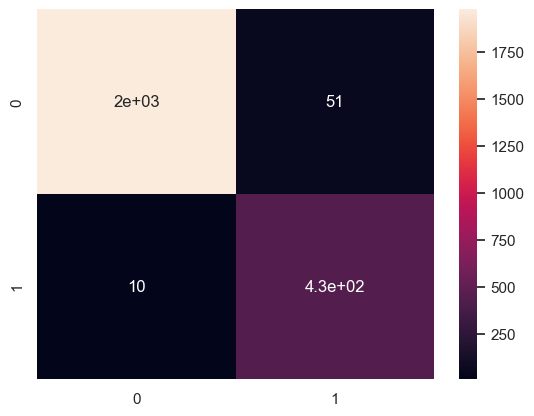

In [12]:
%%timeit -r 1 -n 1
# dblp acm clean jaccard
coeff_train_jaccard_1_1 = getCoeffJaccard(clean_train1['text_left'], clean_train1['text_right'])
real_train1_1 = toInt(clean_train1['label'])
t_train_jaccard_1_1, f_train_jaccard_1_1 = token_threshold(coeff_train_jaccard_1_1, real_train1_1)
print('dblp acm clean jaccard')
print('threshold of the training set is:{}'.format(t_train_jaccard_1_1))
print('f1 score of training set is:{}'.format(f_train_jaccard_1_1))
coeff_test_jaccard_1_1 = getCoeffJaccard(clean_test1['text_left'], clean_test1['text_right'])
real_test1_1 = toInt(clean_test1['label'])
pre_list_jaccard_1_1 = token_prediction(coeff_test_jaccard_1_1, t_train_jaccard_1_1)
pre_jaccard_1_1 = toInt(pre_list_jaccard_1_1)
f_test_jaccard_1_1 = f1_score(real_test1_1, pre_jaccard_1_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_jaccard_1_1))
print(classification_report(real_test1_1, pre_jaccard_1_1))
sns.set()
C2= confusion_matrix(real_test1_1, pre_list_jaccard_1_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)

dblp acm dirty jaccard
threshold of the training set is:0.56
f1 score of training set is:0.9325640100973676
f1 score of the testing set is:0.9265658747300216
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2029
           1       0.89      0.97      0.93       444

    accuracy                           0.97      2473
   macro avg       0.94      0.97      0.95      2473
weighted avg       0.97      0.97      0.97      2473

[[1976   53]
 [  15  429]]
1.84 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


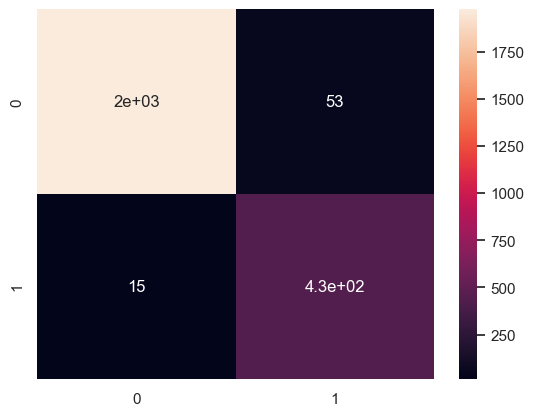

In [13]:
%%timeit -r 1 -n 1
# dblp acm dirty jaccard
coeff_train_jaccard_1_1 = getCoeffJaccard(dirty_train1['text_left'], dirty_train1['text_right'])
real_train1_1 = toInt(dirty_train1['label'])
t_train_jaccard_1_1, f_train_jaccard_1_1 = token_threshold(coeff_train_jaccard_1_1, real_train1_1)
print('dblp acm dirty jaccard')
print('threshold of the training set is:{}'.format(t_train_jaccard_1_1))
print('f1 score of training set is:{}'.format(f_train_jaccard_1_1))
coeff_test_jaccard_1_1 = getCoeffJaccard(dirty_test1['text_left'], dirty_test1['text_right'])
real_test1_1 = toInt(dirty_test1['label'])
pre_list_jaccard_1_1 = token_prediction(coeff_test_jaccard_1_1, t_train_jaccard_1_1)
pre_jaccard_1_1 = toInt(pre_list_jaccard_1_1)
f_test_jaccard_1_1 = f1_score(real_test1_1, pre_jaccard_1_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_jaccard_1_1))
print(classification_report(real_test1_1, pre_jaccard_1_1))
sns.set()
C2= confusion_matrix(real_test1_1, pre_list_jaccard_1_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)

dblp acm clean dice
threshold of the training set is:0.62
f1 score of training set is:0.9222343921139101
f1 score of the testing set is:0.9088937093275489
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2029
           1       0.88      0.94      0.91       444

    accuracy                           0.97      2473
   macro avg       0.93      0.96      0.94      2473
weighted avg       0.97      0.97      0.97      2473

[[1970   59]
 [  25  419]]
1.68 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


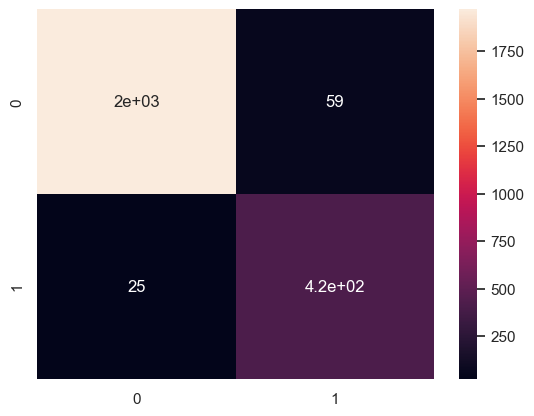

In [14]:
%%timeit -r 1 -n 1
# dblp acm clean dice
coeff_train_dice_1_1 = getCoeffDice(clean_train1['text_left'], clean_train1['text_right'])
real_train1_1 = toInt(clean_train1['label'])
t_train_dice_1_1, f_train_dice_1_1 = token_threshold(coeff_train_dice_1_1, real_train1_1)
print('dblp acm clean dice')
print('threshold of the training set is:{}'.format(t_train_dice_1_1))
print('f1 score of training set is:{}'.format(f_train_dice_1_1))
coeff_test_dice_1_1 = getCoeffDice(clean_test1['text_left'], clean_test1['text_right'])
real_test1_1 = toInt(clean_test1['label'])
pre_list_dice_1_1 = token_prediction(coeff_test_dice_1_1, t_train_dice_1_1)
pre_dice_1_1 = toInt(pre_list_dice_1_1)
f_test_dice_1_1 = f1_score(real_test1_1, pre_dice_1_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_dice_1_1))
print(classification_report(real_test1_1, pre_dice_1_1))
sns.set()
C2= confusion_matrix(real_test1_1, pre_list_dice_1_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)

dblp acm dirty dice
threshold of the training set is:0.61
f1 score of training set is:0.9215116279069768
f1 score of the testing set is:0.9104638619201726
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2029
           1       0.87      0.95      0.91       444

    accuracy                           0.97      2473
   macro avg       0.93      0.96      0.94      2473
weighted avg       0.97      0.97      0.97      2473

[[1968   61]
 [  22  422]]
1.66 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


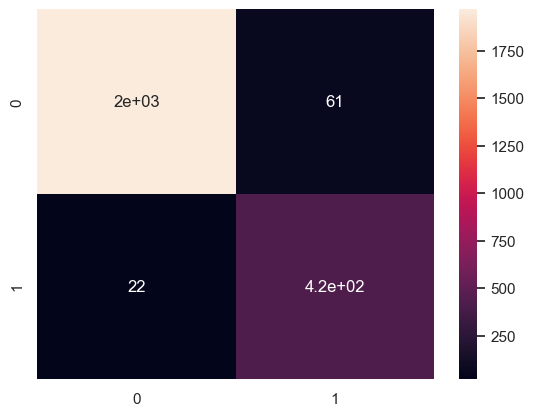

In [15]:
%%timeit -r 1 -n 1
# dblp acm dirty dice
coeff_train_dice_1_1 = getCoeffDice(dirty_train1['text_left'], dirty_train1['text_right'])
real_train1_1 = toInt(dirty_train1['label'])
t_train_dice_1_1, f_train_dice_1_1 = token_threshold(coeff_train_dice_1_1, real_train1_1)
print('dblp acm dirty dice')
print('threshold of the training set is:{}'.format(t_train_dice_1_1))
print('f1 score of training set is:{}'.format(f_train_dice_1_1))
coeff_test_dice_1_1 = getCoeffDice(dirty_test1['text_left'], dirty_test1['text_right'])
real_test1_1 = toInt(dirty_test1['label'])
pre_list_dice_1_1 = token_prediction(coeff_test_dice_1_1, t_train_dice_1_1)
pre_dice_1_1 = toInt(pre_list_dice_1_1)
f_test_dice_1_1 = f1_score(real_test1_1, pre_dice_1_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_dice_1_1))
print(classification_report(real_test1_1, pre_dice_1_1))
sns.set()
C2= confusion_matrix(real_test1_1, pre_list_dice_1_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)

## dblp scholar

### character based

dblp scholar clean character based method
threshold of the training set is:0.5
f1 score of training set is:0.8397338977925612
f1 score of the testing set is:0.838095238095238
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      4672
           1       0.81      0.86      0.84      1070

    accuracy                           0.94      5742
   macro avg       0.89      0.91      0.90      5742
weighted avg       0.94      0.94      0.94      5742

[[4461  211]
 [ 146  924]]
4min 54s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


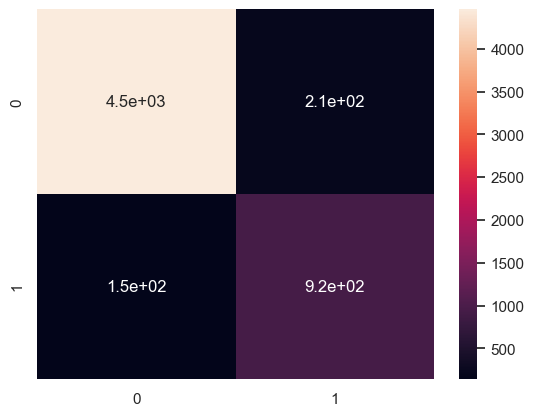

In [16]:
%%timeit -r 1 -n 1
# dblp scholar clean character based
dist_train_char_2_1 = getDistanceChar(clean_train2['text_left'], clean_train2['text_right'])
real_train2_1 = toInt(clean_train2['label'])
t_train_char_2_1, f_train_char_2_1 = max_threshold(dist_train_char_2_1, real_train2_1)
print('dblp scholar clean character based method')
print('threshold of the training set is:{}'.format(t_train_char_2_1))
print('f1 score of training set is:{}'.format(f_train_char_2_1))
dist_test_char_2_1 = getDistanceChar(clean_test2['text_left'], clean_test2['text_right'])
real_test2_1 = toInt(clean_test2['label'])
pre_list_char_2_1 = prediction(dist_test_char_2_1, t_train_char_2_1)
pre_char_2_1 = toInt(pre_list_char_2_1)
f_test_char_2_1 = f1_score(real_test2_1, pre_char_2_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_char_2_1))
print(classification_report(real_test2_1, pre_char_2_1))
sns.set()
C2= confusion_matrix(real_test2_1, pre_list_char_2_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)

dblp scholar dirty character based method
threshold of the training set is:0.51
f1 score of training set is:0.8145285935085007
f1 score of the testing set is:0.8078541374474054
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      4672
           1       0.81      0.81      0.81      1070

    accuracy                           0.93      5742
   macro avg       0.88      0.88      0.88      5742
weighted avg       0.93      0.93      0.93      5742

[[4467  205]
 [ 206  864]]
4min 57s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


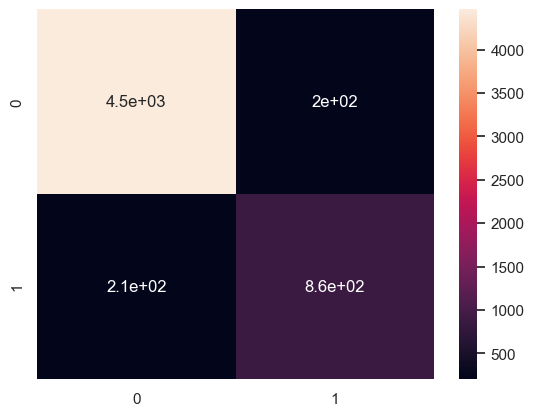

In [17]:
%%timeit -r 1 -n 1
# dblp scholar dirty character based
dist_train_char_2_1 = getDistanceChar(dirty_train2['text_left'], dirty_train2['text_right'])
real_train2_1 = toInt(dirty_train2['label'])
t_train_char_2_1, f_train_char_2_1 = max_threshold(dist_train_char_2_1, real_train2_1)
print('dblp scholar dirty character based method')
print('threshold of the training set is:{}'.format(t_train_char_2_1))
print('f1 score of training set is:{}'.format(f_train_char_2_1))
dist_test_char_2_1 = getDistanceChar(dirty_test2['text_left'], dirty_test2['text_right'])
real_test2_1 = toInt(dirty_test2['label'])
pre_list_char_2_1 = prediction(dist_test_char_2_1, t_train_char_2_1)
pre_char_2_1 = toInt(pre_list_char_2_1)
f_test_char_2_1 = f1_score(real_test2_1, pre_char_2_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_char_2_1))
print(classification_report(real_test2_1, pre_char_2_1))
sns.set()
C2= confusion_matrix(real_test2_1, pre_list_char_2_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)

### crossparsing

dblp scholar clean character crossparsing
threshold of the training set is:0.29
f1 score of training set is:0.8883343730505303
f1 score of the testing set is:0.89014615747289
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4672
           1       0.90      0.88      0.89      1070

    accuracy                           0.96      5742
   macro avg       0.94      0.93      0.93      5742
weighted avg       0.96      0.96      0.96      5742

[[4565  107]
 [ 126  944]]
4min 6s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


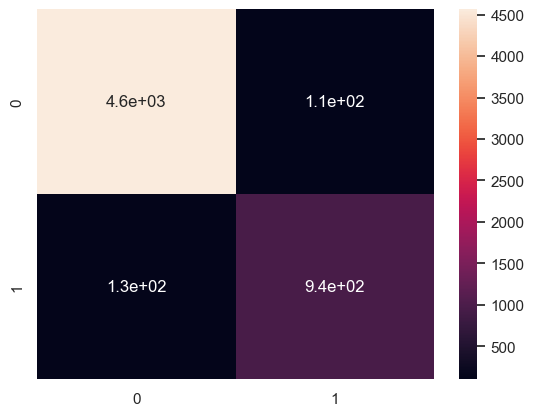

In [18]:
%%timeit -r 1 -n 1
# dblp scholar clean crossparsing
dist_train_cross_2_1 = getDistanceCross(clean_train2['text_left'], clean_train2['text_right'])
real_train2_1 = toInt(clean_train2['label'])
t_train_cross_2_1, f_train_cross_2_1 = max_threshold(dist_train_cross_2_1, real_train2_1)
print('dblp scholar clean character crossparsing')
print('threshold of the training set is:{}'.format(t_train_cross_2_1))
print('f1 score of training set is:{}'.format(f_train_cross_2_1))
dist_test_cross_2_1 = getDistanceCross(clean_test2['text_left'], clean_test2['text_right'])
real_test2_1 = toInt(clean_test2['label'])
pre_list_cross_2_1 = prediction(dist_test_cross_2_1, t_train_cross_2_1)
pre_cross_2_1 = toInt(pre_list_cross_2_1)
f_test_cross_2_1 = f1_score(real_test2_1, pre_cross_2_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_cross_2_1))
print(classification_report(real_test2_1, pre_cross_2_1))
sns.set()
C2= confusion_matrix(real_test2_1, pre_list_cross_2_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)

dblp scholar dirty character crossparsing
threshold of the training set is:0.3
f1 score of training set is:0.8864898210980876
f1 score of the testing set is:0.8938547486033519
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      4672
           1       0.89      0.90      0.89      1070

    accuracy                           0.96      5742
   macro avg       0.93      0.94      0.93      5742
weighted avg       0.96      0.96      0.96      5742

[[4554  118]
 [ 110  960]]
4min 8s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


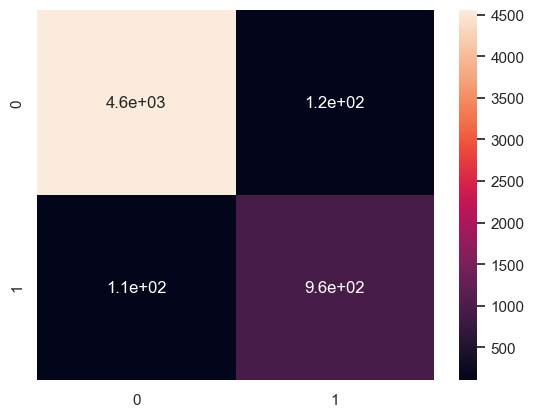

In [19]:
%%timeit -r 1 -n 1
# dblp scholar dirty crossparsing
dist_train_cross_2_1 = getDistanceCross(dirty_train2['text_left'], dirty_train2['text_right'])
real_train2_1 = toInt(dirty_train2['label'])
t_train_cross_2_1, f_train_cross_2_1 = max_threshold(dist_train_cross_2_1, real_train2_1)
print('dblp scholar dirty character crossparsing')
print('threshold of the training set is:{}'.format(t_train_cross_2_1))
print('f1 score of training set is:{}'.format(f_train_cross_2_1))
dist_test_cross_2_1 = getDistanceCross(dirty_test2['text_left'], dirty_test2['text_right'])
real_test2_1 = toInt(dirty_test2['label'])
pre_list_cross_2_1 = prediction(dist_test_cross_2_1, t_train_cross_2_1)
pre_cross_2_1 = toInt(pre_list_cross_2_1)
f_test_cross_2_1 = f1_score(real_test2_1, pre_cross_2_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_cross_2_1))
print(classification_report(real_test2_1, pre_cross_2_1))
sns.set()
C2= confusion_matrix(real_test2_1, pre_list_cross_2_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)

### token based

dblp scholar clean overlap
threshold of the training set is:0.67
f1 score of training set is:0.7991791263559074
f1 score of the testing set is:0.8137992038920832
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      4672
           1       0.77      0.86      0.81      1070

    accuracy                           0.93      5742
   macro avg       0.87      0.90      0.88      5742
weighted avg       0.93      0.93      0.93      5742

[[4401  271]
 [ 150  920]]
3.41 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


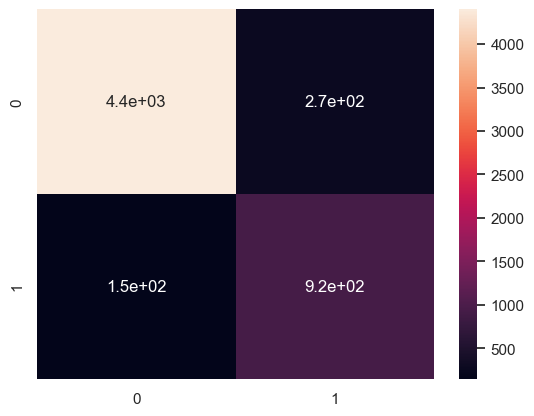

In [20]:
%%timeit -r 1 -n 1
# dblp scholar clean overlap
coeff_train_overlap_2_1 = getCoeffOverlap(clean_train2['text_left'], clean_train2['text_right'])
real_train2_1 = toInt(clean_train2['label'])
t_train_overlap_2_1, f_train_overlap_2_1 = token_threshold(coeff_train_overlap_2_1, real_train2_1)
print('dblp scholar clean overlap')
print('threshold of the training set is:{}'.format(t_train_overlap_2_1))
print('f1 score of training set is:{}'.format(f_train_overlap_2_1))
coeff_test_overlap_2_1 = getCoeffOverlap(clean_test2['text_left'], clean_test2['text_right'])
real_test2_1 = toInt(clean_test2['label'])
pre_list_overlap_2_1 = token_prediction(coeff_test_overlap_2_1, t_train_overlap_2_1)
pre_overlap_2_1 = toInt(pre_list_overlap_2_1)
f_test_overlap_2_1 = f1_score(real_test2_1, pre_overlap_2_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_overlap_2_1))
print(classification_report(real_test2_1, pre_overlap_2_1))
sns.set()
C2= confusion_matrix(real_test2_1, pre_list_overlap_2_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)

dblp scholar dirty overlap
threshold of the training set is:0.67
f1 score of training set is:0.7936925098554534
f1 score of the testing set is:0.8093350946719506
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      4672
           1       0.77      0.86      0.81      1070

    accuracy                           0.92      5742
   macro avg       0.87      0.90      0.88      5742
weighted avg       0.93      0.92      0.93      5742

[[4390  282]
 [ 151  919]]
3.41 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


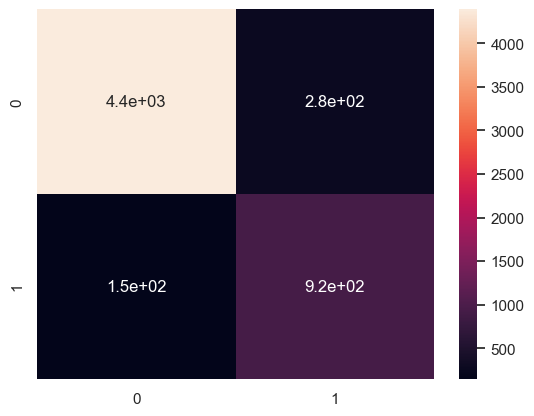

In [21]:
%%timeit -r 1 -n 1
# dblp scholar dirty overlap
coeff_train_overlap_2_1 = getCoeffOverlap(dirty_train2['text_left'], dirty_train2['text_right'])
real_train2_1 = toInt(dirty_train2['label'])
t_train_overlap_2_1, f_train_overlap_2_1 = token_threshold(coeff_train_overlap_2_1, real_train2_1)
print('dblp scholar dirty overlap')
print('threshold of the training set is:{}'.format(t_train_overlap_2_1))
print('f1 score of training set is:{}'.format(f_train_overlap_2_1))
coeff_test_overlap_2_1 = getCoeffOverlap(dirty_test2['text_left'], dirty_test2['text_right'])
real_test2_1 = toInt(dirty_test2['label'])
pre_list_overlap_2_1 = token_prediction(coeff_test_overlap_2_1, t_train_overlap_2_1)
pre_overlap_2_1 = toInt(pre_list_overlap_2_1)
f_test_overlap_2_1 = f1_score(real_test2_1, pre_overlap_2_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_overlap_2_1))
print(classification_report(real_test2_1, pre_overlap_2_1))
sns.set()
C2= confusion_matrix(real_test2_1, pre_list_overlap_2_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)

dblp scholar clean jaccard
threshold of the training set is:0.47000000000000003
f1 score of training set is:0.8724690238742823
f1 score of the testing set is:0.8782051282051282
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      4672
           1       0.86      0.90      0.88      1070

    accuracy                           0.95      5742
   macro avg       0.92      0.93      0.92      5742
weighted avg       0.95      0.95      0.95      5742

[[4517  155]
 [ 111  959]]
3.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


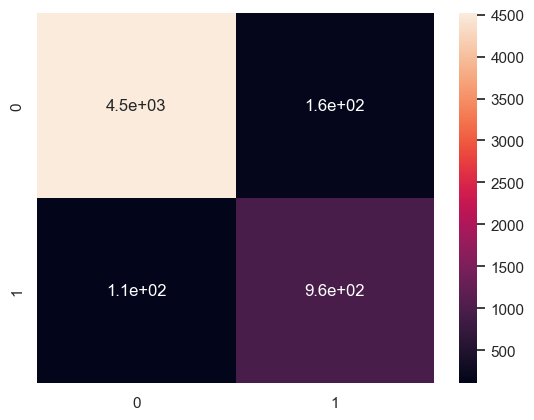

In [22]:
%%timeit -r 1 -n 1
# dblp scholar clean jaccard
coeff_train_jaccard_2_1 = getCoeffJaccard(clean_train2['text_left'], clean_train2['text_right'])
# real_train1_2 = toInt(clean_train1['label'])
real_train2_1 = toInt(clean_train2['label'])
t_train_jaccard_2_1, f_train_jaccard_2_1 = token_threshold(coeff_train_jaccard_2_1, real_train2_1)
print('dblp scholar clean jaccard')
print('threshold of the training set is:{}'.format(t_train_jaccard_2_1))
print('f1 score of training set is:{}'.format(f_train_jaccard_2_1))
coeff_test_jaccard_2_1 = getCoeffJaccard(clean_test2['text_left'], clean_test2['text_right'])
real_test2_1 = toInt(clean_test2['label'])
pre_list_jaccard_2_1 = token_prediction(coeff_test_jaccard_2_1, t_train_jaccard_2_1)
pre_jaccard_2_1 = toInt(pre_list_jaccard_2_1)
f_test_jaccard_2_1 = f1_score(real_test2_1, pre_jaccard_2_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_jaccard_2_1))
print(classification_report(real_test2_1, pre_jaccard_2_1))
sns.set()
C2= confusion_matrix(real_test2_1, pre_list_jaccard_2_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)

dblp scholar dirty jaccard
threshold of the training set is:0.47000000000000003
f1 score of training set is:0.8705599036724865
f1 score of the testing set is:0.88
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      4672
           1       0.86      0.90      0.88      1070

    accuracy                           0.95      5742
   macro avg       0.92      0.93      0.93      5742
weighted avg       0.96      0.95      0.95      5742

[[4510  162]
 [ 102  968]]
3.75 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


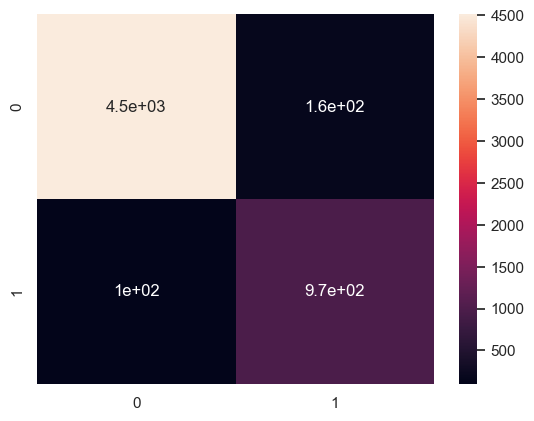

In [23]:
%%timeit -r 1 -n 1
# dblp scholar dirty jaccard
coeff_train_jaccard_2_1 = getCoeffJaccard(dirty_train2['text_left'], dirty_train2['text_right'])
# real_train1_2 = toInt(dirty_train1['label'])
real_train2_1 = toInt(clean_train2['label'])
t_train_jaccard_2_1, f_train_jaccard_2_1 = token_threshold(coeff_train_jaccard_2_1, real_train2_1)
print('dblp scholar dirty jaccard')
print('threshold of the training set is:{}'.format(t_train_jaccard_2_1))
print('f1 score of training set is:{}'.format(f_train_jaccard_2_1))
coeff_test_jaccard_2_1 = getCoeffJaccard(dirty_test2['text_left'], dirty_test2['text_right'])
real_test2_1 = toInt(dirty_test2['label'])
pre_list_jaccard_2_1 = token_prediction(coeff_test_jaccard_2_1, t_train_jaccard_2_1)
pre_jaccard_2_1 = toInt(pre_list_jaccard_2_1)
f_test_jaccard_2_1 = f1_score(real_test2_1, pre_jaccard_2_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_jaccard_2_1))
print(classification_report(real_test2_1, pre_jaccard_2_1))
sns.set()
C2= confusion_matrix(real_test2_1, pre_list_jaccard_2_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)

dblp scholar clean dice
threshold of the training set is:0.54
f1 score of training set is:0.8522055479763528
f1 score of the testing set is:0.860370537731586
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      4672
           1       0.83      0.89      0.86      1070

    accuracy                           0.95      5742
   macro avg       0.90      0.92      0.91      5742
weighted avg       0.95      0.95      0.95      5742

[[4481  191]
 [ 118  952]]
3.49 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


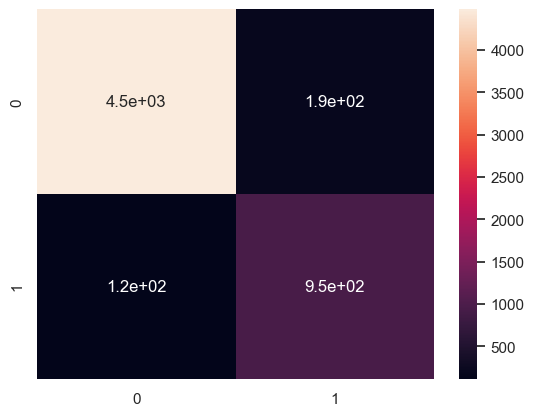

In [24]:
%%timeit -r 1 -n 1
# dblp scholar clean dice
coeff_train_dice_2_1 = getCoeffDice(clean_train2['text_left'], clean_train2['text_right'])
real_train2_1 = toInt(clean_train2['label'])
t_train_dice_2_1, f_train_dice_2_1 = token_threshold(coeff_train_dice_2_1, real_train2_1)
print('dblp scholar clean dice')
print('threshold of the training set is:{}'.format(t_train_dice_2_1))
print('f1 score of training set is:{}'.format(f_train_dice_2_1))
coeff_test_dice_2_1 = getCoeffDice(clean_test2['text_left'], clean_test2['text_right'])
real_test2_1 = toInt(clean_test2['label'])
pre_list_dice_2_1 = token_prediction(coeff_test_dice_2_1, t_train_dice_2_1)
pre_dice_2_1 = toInt(pre_list_dice_2_1)
f_test_dice_2_1 = f1_score(real_test2_1, pre_dice_2_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_dice_2_1))
print(classification_report(real_test2_1, pre_dice_2_1))
sns.set()
C2= confusion_matrix(real_test2_1, pre_list_dice_2_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)

dblp scholar dirty dice
threshold of the training set is:0.54
f1 score of training set is:0.850210970464135
f1 score of the testing set is:0.8558599012123934
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      4672
           1       0.82      0.89      0.86      1070

    accuracy                           0.94      5742
   macro avg       0.90      0.92      0.91      5742
weighted avg       0.95      0.94      0.94      5742

[[4468  204]
 [ 117  953]]
3.44 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


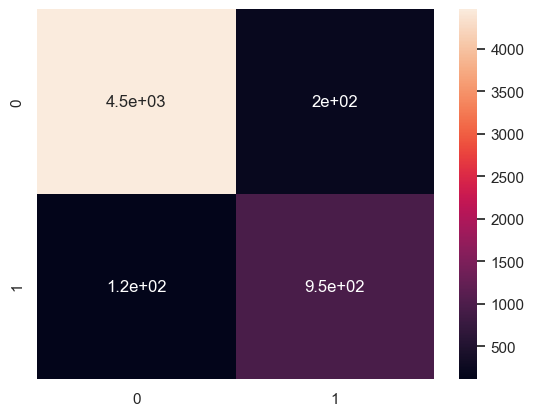

In [25]:
%%timeit -r 1 -n 1
# dblp scholar dirty dice
coeff_train_dice_2_1 = getCoeffDice(dirty_train2['text_left'], dirty_train2['text_right'])
real_train2_1 = toInt(dirty_train2['label'])
t_train_dice_2_1, f_train_dice_2_1 = token_threshold(coeff_train_dice_2_1, real_train2_1)
print('dblp scholar dirty dice')
print('threshold of the training set is:{}'.format(t_train_dice_2_1))
print('f1 score of training set is:{}'.format(f_train_dice_2_1))
coeff_test_dice_2_1 = getCoeffDice(dirty_test2['text_left'], dirty_test2['text_right'])
real_test2_1 = toInt(dirty_test2['label'])
pre_list_dice_2_1 = token_prediction(coeff_test_dice_2_1, t_train_dice_2_1)
pre_dice_2_1 = toInt(pre_list_dice_2_1)
f_test_dice_2_1 = f1_score(real_test2_1, pre_dice_2_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_dice_2_1))
print(classification_report(real_test2_1, pre_dice_2_1))
sns.set()
C2= confusion_matrix(real_test2_1, pre_list_dice_2_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)

## amazon itunes

### character based

amazon itunes clean character based method
threshold of the training set is:0.59
f1 score of training set is:0.4916666666666667
f1 score of the testing set is:0.4675324675324675
              precision    recall  f1-score   support

           0       0.85      0.61      0.71        82
           1       0.36      0.67      0.47        27

    accuracy                           0.62       109
   macro avg       0.60      0.64      0.59       109
weighted avg       0.73      0.62      0.65       109

[[50 32]
 [ 9 18]]
20.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


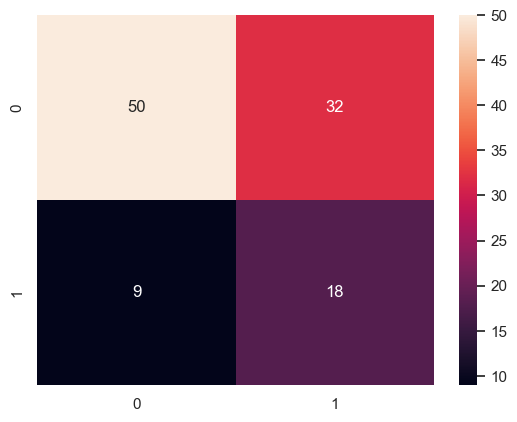

In [26]:
%%timeit -r 1 -n 1
# amazon itunes clean character based
dist_train_char_3_1 = getDistanceChar(clean_train3['text_left'], clean_train3['text_right'])
real_train3_1 = toInt(clean_train3['label'])
t_train_char_3_1, f_train_char_3_1 = max_threshold(dist_train_char_3_1, real_train3_1)
print('amazon itunes clean character based method')
print('threshold of the training set is:{}'.format(t_train_char_3_1))
print('f1 score of training set is:{}'.format(f_train_char_3_1))
dist_test_char_3_1 = getDistanceChar(clean_test3['text_left'], clean_test3['text_right'])
real_test3_1 = toInt(clean_test3['label'])
pre_list_char_3_1 = prediction(dist_test_char_3_1, t_train_char_3_1)
pre_char_3_1 = toInt(pre_list_char_3_1)
f_test_char_3_1 = f1_score(real_test3_1, pre_char_3_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_char_3_1))
print(classification_report(real_test3_1, pre_char_3_1))
sns.set()
C2= confusion_matrix(real_test3_1, pre_list_char_3_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)

amazon itunes dirty character based method
threshold of the training set is:0.71
f1 score of training set is:0.4803149606299213
f1 score of the testing set is:0.41304347826086957
              precision    recall  f1-score   support

           0       0.82      0.44      0.57        82
           1       0.29      0.70      0.41        27

    accuracy                           0.50       109
   macro avg       0.56      0.57      0.49       109
weighted avg       0.69      0.50      0.53       109

[[36 46]
 [ 8 19]]
20 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


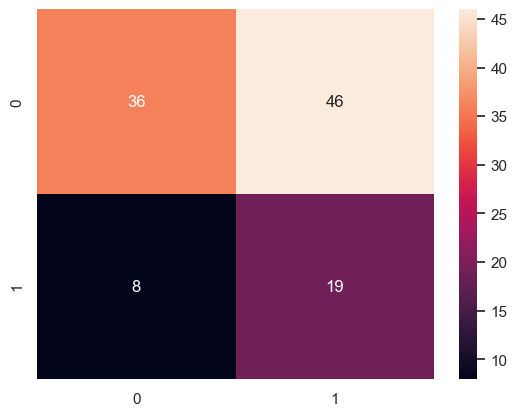

In [27]:
%%timeit -r 1 -n 1
# amazon itunes dirty character based
dist_train_char_3_1 = getDistanceChar(dirty_train3['text_left'], dirty_train3['text_right'])
real_train3_1 = toInt(dirty_train3['label'])
t_train_char_3_1, f_train_char_3_1 = max_threshold(dist_train_char_3_1, real_train3_1)
print('amazon itunes dirty character based method')
print('threshold of the training set is:{}'.format(t_train_char_3_1))
print('f1 score of training set is:{}'.format(f_train_char_3_1))
dist_test_char_3_1 = getDistanceChar(dirty_test3['text_left'], dirty_test3['text_right'])
real_test3_1 = toInt(dirty_test3['label'])
pre_list_char_3_1 = prediction(dist_test_char_3_1, t_train_char_3_1)
pre_char_3_1 = toInt(pre_list_char_3_1)
f_test_char_3_1 = f1_score(real_test3_1, pre_char_3_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_char_3_1))
print(classification_report(real_test3_1, pre_char_3_1))
sns.set()
C2= confusion_matrix(real_test3_1, pre_list_char_3_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)

### crossparsing

amazon itunes clean character crossparsing
threshold of the training set is:0.4
f1 score of training set is:0.5254237288135593
f1 score of the testing set is:0.5063291139240507
              precision    recall  f1-score   support

           0       0.88      0.61      0.72        82
           1       0.38      0.74      0.51        27

    accuracy                           0.64       109
   macro avg       0.63      0.68      0.61       109
weighted avg       0.76      0.64      0.67       109

[[50 32]
 [ 7 20]]
17.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


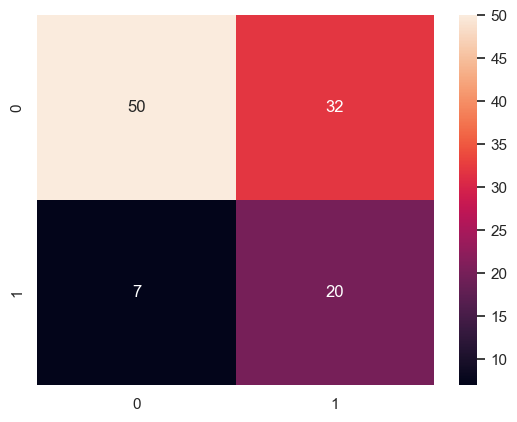

In [28]:
%%timeit -r 1 -n 1
# amazon itunes clean crossparsing
dist_train_cross_3_1 = getDistanceCross(clean_train3['text_left'], clean_train3['text_right'])
real_train3_1 = toInt(clean_train3['label'])
t_train_cross_3_1, f_train_cross_3_1 = max_threshold(dist_train_cross_3_1, real_train3_1)
print('amazon itunes clean character crossparsing')
print('threshold of the training set is:{}'.format(t_train_cross_3_1))
print('f1 score of training set is:{}'.format(f_train_cross_3_1))
dist_test_cross_3_1 = getDistanceCross(clean_test3['text_left'], clean_test3['text_right'])
real_test3_1 = toInt(clean_test3['label'])
pre_list_cross_3_1 = prediction(dist_test_cross_3_1, t_train_cross_3_1)
pre_cross_3_1 = toInt(pre_list_cross_3_1)
f_test_cross_3_1 = f1_score(real_test3_1, pre_cross_3_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_cross_3_1))
print(classification_report(real_test3_1, pre_cross_3_1))
sns.set()
C2= confusion_matrix(real_test3_1, pre_list_cross_3_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)

amazon itunes dirty character crossparsing
threshold of the training set is:0.46
f1 score of training set is:0.5281690140845071
f1 score of the testing set is:0.5263157894736842
              precision    recall  f1-score   support

           0       0.95      0.48      0.63        82
           1       0.37      0.93      0.53        27

    accuracy                           0.59       109
   macro avg       0.66      0.70      0.58       109
weighted avg       0.81      0.59      0.61       109

[[39 43]
 [ 2 25]]
17.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


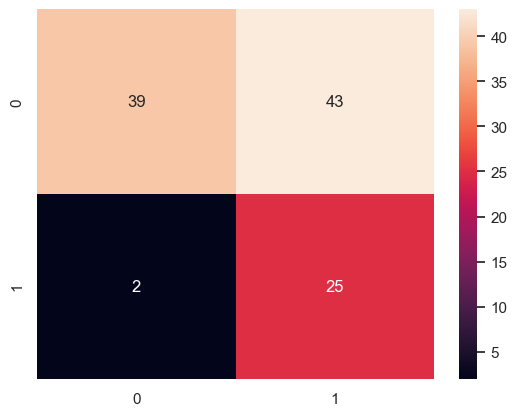

In [29]:
%%timeit -r 1 -n 1
# amazon itunes dirty crossparsing
dist_train_cross_3_1 = getDistanceCross(dirty_train3['text_left'], dirty_train3['text_right'])
real_train3_1 = toInt(dirty_train3['label'])
t_train_cross_3_1, f_train_cross_3_1 = max_threshold(dist_train_cross_3_1, real_train3_1)
print('amazon itunes dirty character crossparsing')
print('threshold of the training set is:{}'.format(t_train_cross_3_1))
print('f1 score of training set is:{}'.format(f_train_cross_3_1))
dist_test_cross_3_1 = getDistanceCross(dirty_test3['text_left'], dirty_test3['text_right'])
real_test3_1 = toInt(dirty_test3['label'])
pre_list_cross_3_1 = prediction(dist_test_cross_3_1, t_train_cross_3_1)
pre_cross_3_1 = toInt(pre_list_cross_3_1)
f_test_cross_3_1 = f1_score(real_test3_1, pre_cross_3_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_cross_3_1))
print(classification_report(real_test3_1, pre_cross_3_1))
sns.set()
C2= confusion_matrix(real_test3_1, pre_list_cross_3_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)

### token based

amazon itunes clean overlap
threshold of the training set is:0.59
f1 score of training set is:0.6832298136645963
f1 score of the testing set is:0.6461538461538462
              precision    recall  f1-score   support

           0       0.92      0.79      0.85        82
           1       0.55      0.78      0.65        27

    accuracy                           0.79       109
   macro avg       0.73      0.79      0.75       109
weighted avg       0.83      0.79      0.80       109

[[65 17]
 [ 6 21]]
195 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


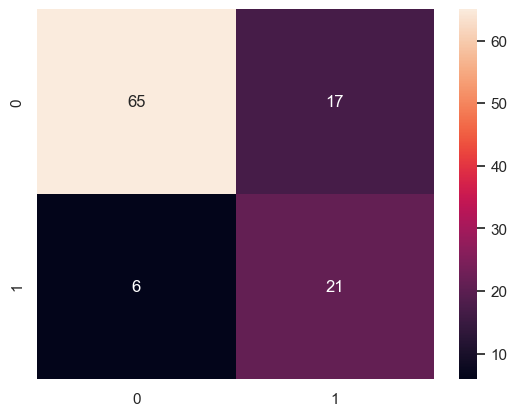

In [30]:
%%timeit -r 1 -n 1
# amazon itunes clean overlap
coeff_train_overlap_3_1 = getCoeffOverlap(clean_train3['text_left'], clean_train3['text_right'])
real_train3_1 = toInt(clean_train3['label'])
t_train_overlap_3_1, f_train_overlap_3_1 = token_threshold(coeff_train_overlap_3_1, real_train3_1)
print('amazon itunes clean overlap')
print('threshold of the training set is:{}'.format(t_train_overlap_3_1))
print('f1 score of training set is:{}'.format(f_train_overlap_3_1))
coeff_test_overlap_3_1 = getCoeffOverlap(clean_test3['text_left'], clean_test3['text_right'])
real_test3_1 = toInt(clean_test3['label'])
pre_list_overlap_3_1 = token_prediction(coeff_test_overlap_3_1, t_train_overlap_3_1)
pre_overlap_3_1 = toInt(pre_list_overlap_3_1)
f_test_overlap_3_1 = f1_score(real_test3_1, pre_overlap_3_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_overlap_3_1))
print(classification_report(real_test3_1, pre_overlap_3_1))
sns.set()
C2= confusion_matrix(real_test3_1, pre_list_overlap_3_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)

amazon itunes dirty overlap
threshold of the training set is:0.59
f1 score of training set is:0.6832298136645963
f1 score of the testing set is:0.6461538461538462
              precision    recall  f1-score   support

           0       0.92      0.79      0.85        82
           1       0.55      0.78      0.65        27

    accuracy                           0.79       109
   macro avg       0.73      0.79      0.75       109
weighted avg       0.83      0.79      0.80       109

[[65 17]
 [ 6 21]]
192 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


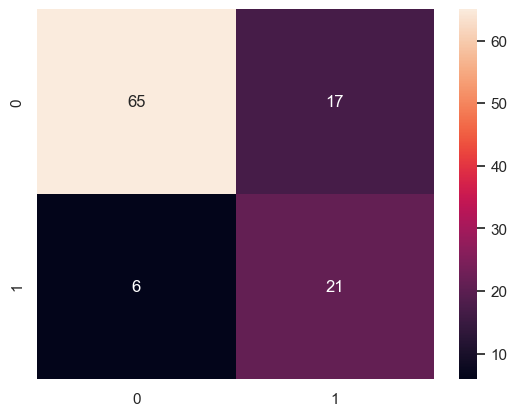

In [31]:
%%timeit -r 1 -n 1
# amazon itunes dirty overlap
coeff_train_overlap_3_1 = getCoeffOverlap(dirty_train3['text_left'], dirty_train3['text_right'])
real_train3_1 = toInt(dirty_train3['label'])
t_train_overlap_3_1, f_train_overlap_3_1 = token_threshold(coeff_train_overlap_3_1, real_train3_1)
print('amazon itunes dirty overlap')
print('threshold of the training set is:{}'.format(t_train_overlap_3_1))
print('f1 score of training set is:{}'.format(f_train_overlap_3_1))
coeff_test_overlap_3_1 = getCoeffOverlap(dirty_test3['text_left'], dirty_test3['text_right'])
real_test3_1 = toInt(dirty_test3['label'])
pre_list_overlap_3_1 = token_prediction(coeff_test_overlap_3_1, t_train_overlap_3_1)
pre_overlap_3_1 = toInt(pre_list_overlap_3_1)
f_test_overlap_3_1 = f1_score(real_test3_1, pre_overlap_3_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_overlap_3_1))
print(classification_report(real_test3_1, pre_overlap_3_1))
sns.set()
C2= confusion_matrix(real_test3_1, pre_list_overlap_3_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)

amazon itunes clean jaccard
threshold of the training set is:0.56
f1 score of training set is:0.5263157894736842
f1 score of the testing set is:0.48
              precision    recall  f1-score   support

           0       0.83      0.87      0.85        82
           1       0.52      0.44      0.48        27

    accuracy                           0.76       109
   macro avg       0.67      0.66      0.66       109
weighted avg       0.75      0.76      0.75       109

[[71 11]
 [15 12]]
205 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


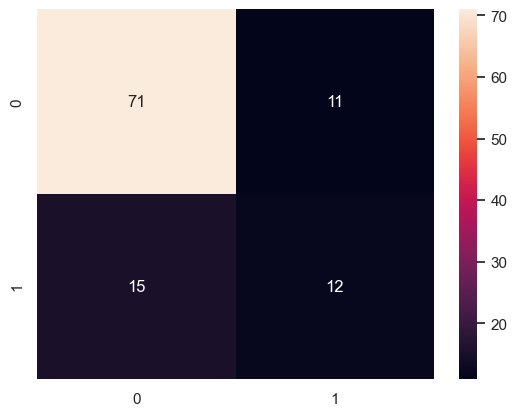

In [32]:
%%timeit -r 1 -n 1
# amazon itunes clean jaccard
coeff_train_jaccard_3_1 = getCoeffJaccard(clean_train3['text_left'], clean_train3['text_right'])
# real_train1_3 = toInt(clean_train3['label'])
real_train3_1 = toInt(clean_train3['label'])
t_train_jaccard_3_1, f_train_jaccard_3_1 = token_threshold(coeff_train_jaccard_3_1, real_train3_1)
print('amazon itunes clean jaccard')
print('threshold of the training set is:{}'.format(t_train_jaccard_3_1))
print('f1 score of training set is:{}'.format(f_train_jaccard_3_1))
coeff_test_jaccard_3_1 = getCoeffJaccard(clean_test3['text_left'], clean_test3['text_right'])
real_test3_1 = toInt(clean_test3['label'])
pre_list_jaccard_3_1 = token_prediction(coeff_test_jaccard_3_1, t_train_jaccard_3_1)
pre_jaccard_3_1 = toInt(pre_list_jaccard_3_1)
f_test_jaccard_3_1 = f1_score(real_test3_1, pre_jaccard_3_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_jaccard_3_1))
print(classification_report(real_test3_1, pre_jaccard_3_1))
sns.set()
C2= confusion_matrix(real_test3_1, pre_list_jaccard_3_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)

amazon itunes dirty jaccard
threshold of the training set is:0.56
f1 score of training set is:0.5263157894736842
f1 score of the testing set is:0.48
              precision    recall  f1-score   support

           0       0.83      0.87      0.85        82
           1       0.52      0.44      0.48        27

    accuracy                           0.76       109
   macro avg       0.67      0.66      0.66       109
weighted avg       0.75      0.76      0.75       109

[[71 11]
 [15 12]]
203 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


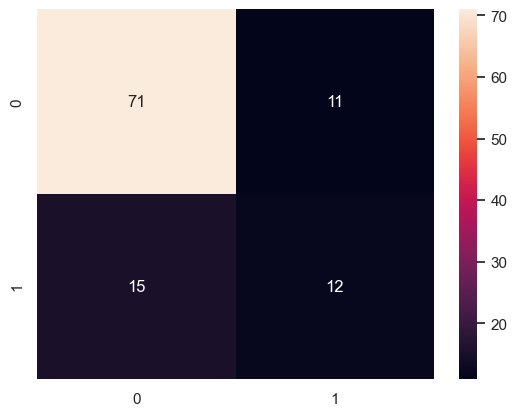

In [33]:
%%timeit -r 1 -n 1
# amazon itunes dirty jaccard
coeff_train_jaccard_3_1 = getCoeffJaccard(dirty_train3['text_left'], dirty_train3['text_right'])
# real_train1_3 = toInt(dirty_train3['label'])
real_train3_1 = toInt(clean_train3['label'])
t_train_jaccard_3_1, f_train_jaccard_3_1 = token_threshold(coeff_train_jaccard_3_1, real_train3_1)
print('amazon itunes dirty jaccard')
print('threshold of the training set is:{}'.format(t_train_jaccard_3_1))
print('f1 score of training set is:{}'.format(f_train_jaccard_3_1))
coeff_test_jaccard_3_1 = getCoeffJaccard(dirty_test3['text_left'], dirty_test3['text_right'])
real_test3_1 = toInt(dirty_test3['label'])
pre_list_jaccard_3_1 = token_prediction(coeff_test_jaccard_3_1, t_train_jaccard_3_1)
pre_jaccard_3_1 = toInt(pre_list_jaccard_3_1)
f_test_jaccard_3_1 = f1_score(real_test3_1, pre_jaccard_3_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_jaccard_3_1))
print(classification_report(real_test3_1, pre_jaccard_3_1))
sns.set()
C2= confusion_matrix(real_test3_1, pre_list_jaccard_3_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)

amazon itunes clean dice
threshold of the training set is:0.49
f1 score of training set is:0.558659217877095
f1 score of the testing set is:0.45901639344262296
              precision    recall  f1-score   support

           0       0.83      0.76      0.79        82
           1       0.41      0.52      0.46        27

    accuracy                           0.70       109
   macro avg       0.62      0.64      0.62       109
weighted avg       0.72      0.70      0.71       109

[[62 20]
 [13 14]]
195 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


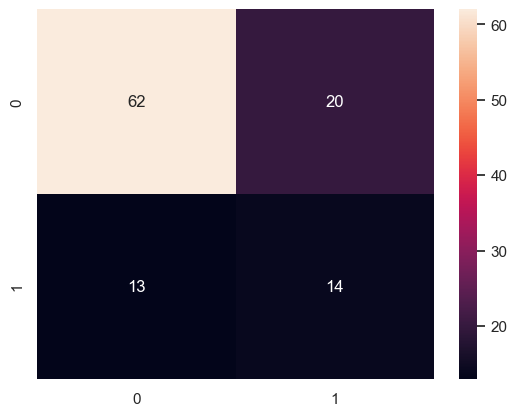

In [34]:
%%timeit -r 1 -n 1
# amazon itunes clean dice
coeff_train_dice_3_1 = getCoeffDice(clean_train3['text_left'], clean_train3['text_right'])
real_train3_1 = toInt(clean_train3['label'])
t_train_dice_3_1, f_train_dice_3_1 = token_threshold(coeff_train_dice_3_1, real_train3_1)
print('amazon itunes clean dice')
print('threshold of the training set is:{}'.format(t_train_dice_3_1))
print('f1 score of training set is:{}'.format(f_train_dice_3_1))
coeff_test_dice_3_1 = getCoeffDice(clean_test3['text_left'], clean_test3['text_right'])
real_test3_1 = toInt(clean_test3['label'])
pre_list_dice_3_1 = token_prediction(coeff_test_dice_3_1, t_train_dice_3_1)
pre_dice_3_1 = toInt(pre_list_dice_3_1)
f_test_dice_3_1 = f1_score(real_test3_1, pre_dice_3_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_dice_3_1))
print(classification_report(real_test3_1, pre_dice_3_1))
sns.set()
C2= confusion_matrix(real_test3_1, pre_list_dice_3_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)

amazon itunes dirty dice
threshold of the training set is:0.49
f1 score of training set is:0.558659217877095
f1 score of the testing set is:0.45901639344262296
              precision    recall  f1-score   support

           0       0.83      0.76      0.79        82
           1       0.41      0.52      0.46        27

    accuracy                           0.70       109
   macro avg       0.62      0.64      0.62       109
weighted avg       0.72      0.70      0.71       109

[[62 20]
 [13 14]]
191 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


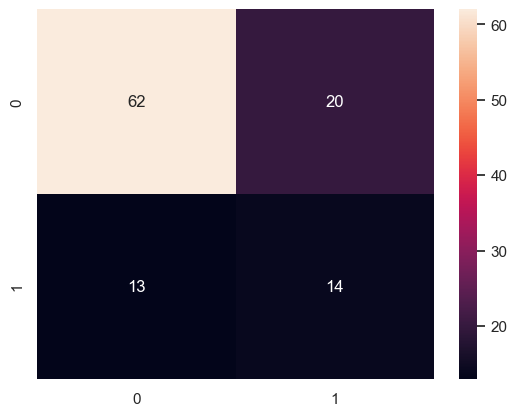

In [35]:
%%timeit -r 1 -n 1
# amazon itunes dirty dice
coeff_train_dice_3_1 = getCoeffDice(dirty_train3['text_left'], dirty_train3['text_right'])
real_train3_1 = toInt(dirty_train3['label'])
t_train_dice_3_1, f_train_dice_3_1 = token_threshold(coeff_train_dice_3_1, real_train3_1)
print('amazon itunes dirty dice')
print('threshold of the training set is:{}'.format(t_train_dice_3_1))
print('f1 score of training set is:{}'.format(f_train_dice_3_1))
coeff_test_dice_3_1 = getCoeffDice(dirty_test3['text_left'], dirty_test3['text_right'])
real_test3_1 = toInt(dirty_test3['label'])
pre_list_dice_3_1 = token_prediction(coeff_test_dice_3_1, t_train_dice_3_1)
pre_dice_3_1 = toInt(pre_list_dice_3_1)
f_test_dice_3_1 = f1_score(real_test3_1, pre_dice_3_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_dice_3_1))
print(classification_report(real_test3_1, pre_dice_3_1))
sns.set()
C2= confusion_matrix(real_test3_1, pre_list_dice_3_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)

## walmart amazon

### character based

walmart amazon clean character based method
threshold of the training set is:0.36
f1 score of training set is:0.2543554006968641
f1 score of the testing set is:0.2789473684210526
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1856
           1       0.28      0.27      0.28       193

    accuracy                           0.87      2049
   macro avg       0.60      0.60      0.60      2049
weighted avg       0.86      0.87      0.87      2049

[[1722  134]
 [ 140   53]]
1min 36s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


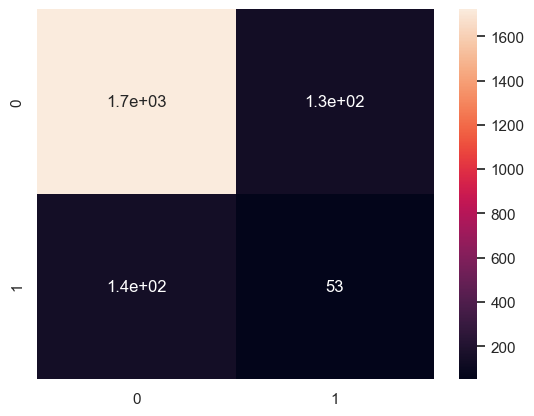

In [36]:
%%timeit -r 1 -n 1
# walmart amazon clean character based
dist_train_char_4_1 = getDistanceChar(clean_train4['text_left'], clean_train4['text_right'])
real_train4_1 = toInt(clean_train4['label'])
t_train_char_4_1, f_train_char_4_1 = max_threshold(dist_train_char_4_1, real_train4_1)
print('walmart amazon clean character based method')
print('threshold of the training set is:{}'.format(t_train_char_4_1))
print('f1 score of training set is:{}'.format(f_train_char_4_1))
dist_test_char_4_1 = getDistanceChar(clean_test4['text_left'], clean_test4['text_right'])
real_test4_1 = toInt(clean_test4['label'])
pre_list_char_4_1 = prediction(dist_test_char_4_1, t_train_char_4_1)
pre_char_4_1 = toInt(pre_list_char_4_1)
f_test_char_4_1 = f1_score(real_test4_1, pre_char_4_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_char_4_1))
print(classification_report(real_test4_1, pre_char_4_1))
sns.set()
C2= confusion_matrix(real_test4_1, pre_list_char_4_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)

walmart amazon dirty character based method
threshold of the training set is:0.43
f1 score of training set is:0.23831070889894418
f1 score of the testing set is:0.24586288416075652
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1856
           1       0.23      0.27      0.25       193

    accuracy                           0.84      2049
   macro avg       0.57      0.59      0.58      2049
weighted avg       0.86      0.84      0.85      2049

[[1678  178]
 [ 141   52]]
1min 36s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


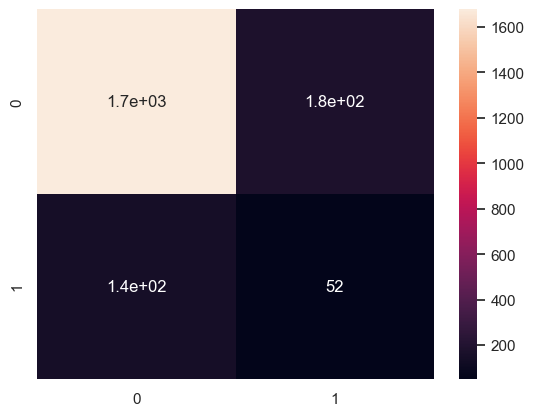

In [37]:
%%timeit -r 1 -n 1
# walmart amazon dirty character based
dist_train_char_4_1 = getDistanceChar(dirty_train4['text_left'], dirty_train4['text_right'])
real_train4_1 = toInt(dirty_train4['label'])
t_train_char_4_1, f_train_char_4_1 = max_threshold(dist_train_char_4_1, real_train4_1)
print('walmart amazon dirty character based method')
print('threshold of the training set is:{}'.format(t_train_char_4_1))
print('f1 score of training set is:{}'.format(f_train_char_4_1))
dist_test_char_4_1 = getDistanceChar(dirty_test4['text_left'], dirty_test4['text_right'])
real_test4_1 = toInt(dirty_test4['label'])
pre_list_char_4_1 = prediction(dist_test_char_4_1, t_train_char_4_1)
pre_char_4_1 = toInt(pre_list_char_4_1)
f_test_char_4_1 = f1_score(real_test4_1, pre_char_4_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_char_4_1))
print(classification_report(real_test4_1, pre_char_4_1))
sns.set()
C2= confusion_matrix(real_test4_1, pre_list_char_4_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)

### crossparsing

amazon itunes clean character crossparsing
threshold of the training set is:0.28
f1 score of training set is:0.4316436251920123
f1 score of the testing set is:0.42990654205607476
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1856
           1       0.39      0.48      0.43       193

    accuracy                           0.88      2049
   macro avg       0.67      0.70      0.68      2049
weighted avg       0.89      0.88      0.89      2049

[[1713  143]
 [ 101   92]]
1min 18s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


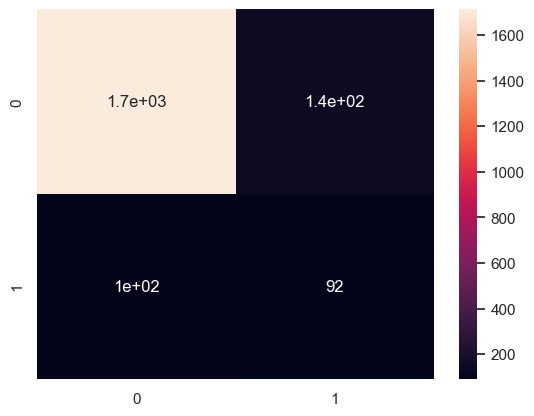

In [38]:
%%timeit -r 1 -n 1
# walmart amazon clean crossparsing
dist_train_cross_4_1 = getDistanceCross(clean_train4['text_left'], clean_train4['text_right'])
real_train4_1 = toInt(clean_train4['label'])
t_train_cross_4_1, f_train_cross_4_1 = max_threshold(dist_train_cross_4_1, real_train4_1)
print('amazon itunes clean character crossparsing')
print('threshold of the training set is:{}'.format(t_train_cross_4_1))
print('f1 score of training set is:{}'.format(f_train_cross_4_1))
dist_test_cross_4_1 = getDistanceCross(clean_test4['text_left'], clean_test4['text_right'])
real_test4_1 = toInt(clean_test4['label'])
pre_list_cross_4_1 = prediction(dist_test_cross_4_1, t_train_cross_4_1)
pre_cross_4_1 = toInt(pre_list_cross_4_1)
f_test_cross_4_1 = f1_score(real_test4_1, pre_cross_4_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_cross_4_1))
print(classification_report(real_test4_1, pre_cross_4_1))
sns.set()
C2= confusion_matrix(real_test4_1, pre_list_cross_4_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)

amazon itunes dirty character crossparsing
threshold of the training set is:0.29
f1 score of training set is:0.4147812971342383
f1 score of the testing set is:0.41002277904328016
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1856
           1       0.37      0.47      0.41       193

    accuracy                           0.87      2049
   macro avg       0.65      0.69      0.67      2049
weighted avg       0.89      0.87      0.88      2049

[[1700  156]
 [ 103   90]]
1min 16s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


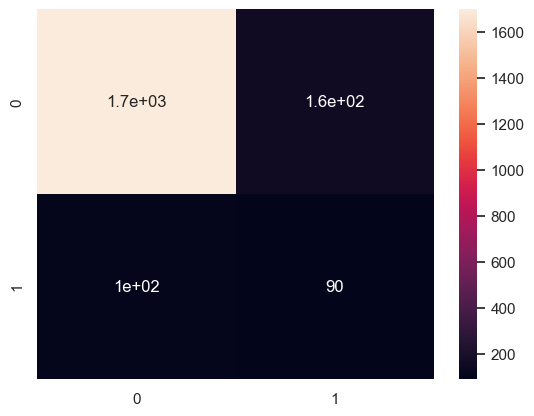

In [39]:
%%timeit -r 1 -n 1
# walmart amazon dirty crossparsing
dist_train_cross_4_1 = getDistanceCross(dirty_train4['text_left'], dirty_train4['text_right'])
real_train4_1 = toInt(dirty_train4['label'])
t_train_cross_4_1, f_train_cross_4_1 = max_threshold(dist_train_cross_4_1, real_train4_1)
print('amazon itunes dirty character crossparsing')
print('threshold of the training set is:{}'.format(t_train_cross_4_1))
print('f1 score of training set is:{}'.format(f_train_cross_4_1))
dist_test_cross_4_1 = getDistanceCross(dirty_test4['text_left'], dirty_test4['text_right'])
real_test4_1 = toInt(dirty_test4['label'])
pre_list_cross_4_1 = prediction(dist_test_cross_4_1, t_train_cross_4_1)
pre_cross_4_1 = toInt(pre_list_cross_4_1)
f_test_cross_4_1 = f1_score(real_test4_1, pre_cross_4_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_cross_4_1))
print(classification_report(real_test4_1, pre_cross_4_1))
sns.set()
C2= confusion_matrix(real_test4_1, pre_list_cross_4_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)

### token based

walmart amazon clean overlap
threshold of the training set is:0.59
f1 score of training set is:0.39761092150170646
f1 score of the testing set is:0.42713567839195987
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1856
           1       0.41      0.44      0.43       193

    accuracy                           0.89      2049
   macro avg       0.68      0.69      0.68      2049
weighted avg       0.89      0.89      0.89      2049

[[1736  120]
 [ 108   85]]
1.25 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


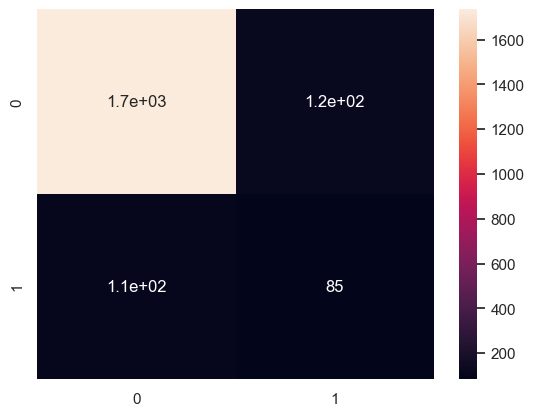

In [40]:
%%timeit -r 1 -n 1
# walmart amazon clean overlap
coeff_train_overlap_4_1 = getCoeffOverlap(clean_train4['text_left'], clean_train4['text_right'])
real_train4_1 = toInt(clean_train4['label'])
t_train_overlap_4_1, f_train_overlap_4_1 = token_threshold(coeff_train_overlap_4_1, real_train4_1)
print('walmart amazon clean overlap')
print('threshold of the training set is:{}'.format(t_train_overlap_4_1))
print('f1 score of training set is:{}'.format(f_train_overlap_4_1))
coeff_test_overlap_4_1 = getCoeffOverlap(clean_test4['text_left'], clean_test4['text_right'])
real_test4_1 = toInt(clean_test4['label'])
pre_list_overlap_4_1 = token_prediction(coeff_test_overlap_4_1, t_train_overlap_4_1)
pre_overlap_4_1 = toInt(pre_list_overlap_4_1)
f_test_overlap_4_1 = f1_score(real_test4_1, pre_overlap_4_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_overlap_4_1))
print(classification_report(real_test4_1, pre_overlap_4_1))
sns.set()
C2= confusion_matrix(real_test4_1, pre_list_overlap_4_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)

walmart amazon dirty overlap
threshold of the training set is:0.59
f1 score of training set is:0.39761092150170646
f1 score of the testing set is:0.42713567839195987
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1856
           1       0.41      0.44      0.43       193

    accuracy                           0.89      2049
   macro avg       0.68      0.69      0.68      2049
weighted avg       0.89      0.89      0.89      2049

[[1736  120]
 [ 108   85]]
1.25 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


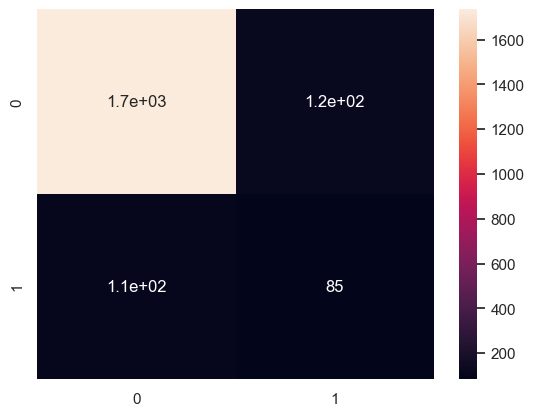

In [41]:
%%timeit -r 1 -n 1
# walmart amazon dirty overlap
coeff_train_overlap_4_1 = getCoeffOverlap(dirty_train4['text_left'], dirty_train4['text_right'])
real_train4_1 = toInt(dirty_train4['label'])
t_train_overlap_4_1, f_train_overlap_4_1 = token_threshold(coeff_train_overlap_4_1, real_train4_1)
print('walmart amazon dirty overlap')
print('threshold of the training set is:{}'.format(t_train_overlap_4_1))
print('f1 score of training set is:{}'.format(f_train_overlap_4_1))
coeff_test_overlap_4_1 = getCoeffOverlap(dirty_test4['text_left'], dirty_test4['text_right'])
real_test4_1 = toInt(dirty_test4['label'])
pre_list_overlap_4_1 = token_prediction(coeff_test_overlap_4_1, t_train_overlap_4_1)
pre_overlap_4_1 = toInt(pre_list_overlap_4_1)
f_test_overlap_4_1 = f1_score(real_test4_1, pre_overlap_4_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_overlap_4_1))
print(classification_report(real_test4_1, pre_overlap_4_1))
sns.set()
C2= confusion_matrix(real_test4_1, pre_list_overlap_4_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)

walmart amazon clean jaccard
threshold of the training set is:0.5
f1 score of training set is:0.4193792581377744
f1 score of the testing set is:0.42685851318944845
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1856
           1       0.40      0.46      0.43       193

    accuracy                           0.88      2049
   macro avg       0.67      0.69      0.68      2049
weighted avg       0.89      0.88      0.89      2049

[[1721  135]
 [ 104   89]]
1.34 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


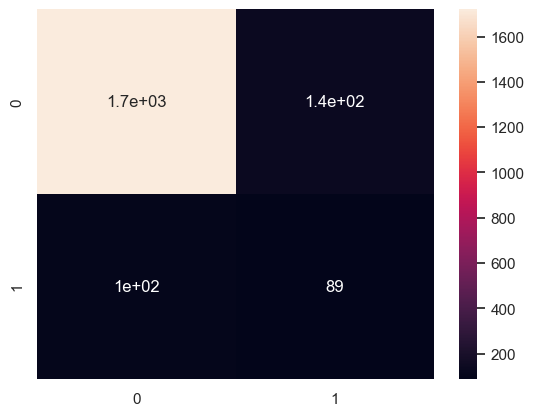

In [42]:
%%timeit -r 1 -n 1
# walmart amazon clean jaccard
coeff_train_jaccard_4_1 = getCoeffJaccard(clean_train4['text_left'], clean_train4['text_right'])
real_train4_1 = toInt(clean_train4['label'])
t_train_jaccard_4_1, f_train_jaccard_4_1 = token_threshold(coeff_train_jaccard_4_1, real_train4_1)
print('walmart amazon clean jaccard')
print('threshold of the training set is:{}'.format(t_train_jaccard_4_1))
print('f1 score of training set is:{}'.format(f_train_jaccard_4_1))
coeff_test_jaccard_4_1 = getCoeffJaccard(clean_test4['text_left'], clean_test4['text_right'])
real_test4_1 = toInt(clean_test4['label'])
pre_list_jaccard_4_1 = token_prediction(coeff_test_jaccard_4_1, t_train_jaccard_4_1)
pre_jaccard_4_1 = toInt(pre_list_jaccard_4_1)
f_test_jaccard_4_1 = f1_score(real_test4_1, pre_jaccard_4_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_jaccard_4_1))
print(classification_report(real_test4_1, pre_jaccard_4_1))
sns.set()
C2= confusion_matrix(real_test4_1, pre_list_jaccard_4_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)

walmart amazon dirty jaccard
threshold of the training set is:0.5
f1 score of training set is:0.4193792581377744
f1 score of the testing set is:0.42685851318944845
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1856
           1       0.40      0.46      0.43       193

    accuracy                           0.88      2049
   macro avg       0.67      0.69      0.68      2049
weighted avg       0.89      0.88      0.89      2049

[[1721  135]
 [ 104   89]]
1.33 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


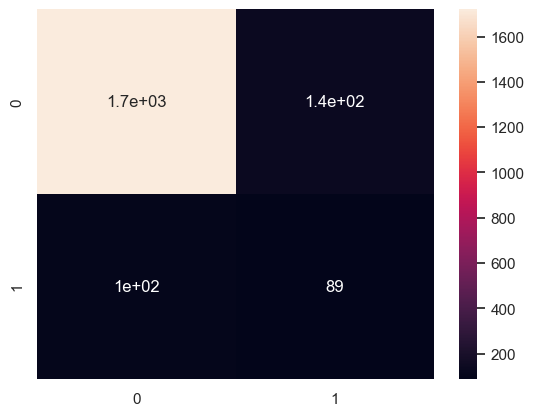

In [43]:
%%timeit -r 1 -n 1
# walmart amazon dirty jaccard
coeff_train_jaccard_4_1 = getCoeffJaccard(dirty_train4['text_left'], dirty_train4['text_right'])
real_train4_1 = toInt(dirty_train4['label'])
t_train_jaccard_4_1, f_train_jaccard_4_1 = token_threshold(coeff_train_jaccard_4_1, real_train4_1)
print('walmart amazon dirty jaccard')
print('threshold of the training set is:{}'.format(t_train_jaccard_4_1))
print('f1 score of training set is:{}'.format(f_train_jaccard_4_1))
coeff_test_jaccard_4_1 = getCoeffJaccard(dirty_test4['text_left'], dirty_test4['text_right'])
real_test4_1 = toInt(dirty_test4['label'])
pre_list_jaccard_4_1 = token_prediction(coeff_test_jaccard_4_1, t_train_jaccard_4_1)
pre_jaccard_4_1 = toInt(pre_list_jaccard_4_1)
f_test_jaccard_4_1 = f1_score(real_test4_1, pre_jaccard_4_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_jaccard_4_1))
print(classification_report(real_test4_1, pre_jaccard_4_1))
sns.set()
C2= confusion_matrix(real_test4_1, pre_list_jaccard_4_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)

walmart amazon clean dice
threshold of the training set is:0.53
f1 score of training set is:0.3946037099494098
f1 score of the testing set is:0.41309823677581864
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1856
           1       0.40      0.42      0.41       193

    accuracy                           0.89      2049
   macro avg       0.67      0.68      0.68      2049
weighted avg       0.89      0.89      0.89      2049

[[1734  122]
 [ 111   82]]
1.24 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


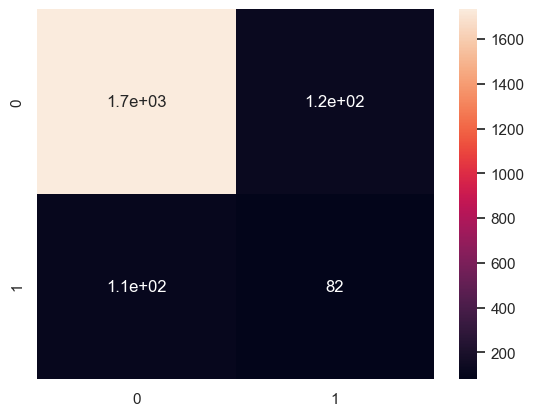

In [44]:
%%timeit -r 1 -n 1
# walmart amazon clean dice
coeff_train_dice_4_1 = getCoeffDice(clean_train4['text_left'], clean_train4['text_right'])
real_train4_1 = toInt(clean_train4['label'])
t_train_dice_4_1, f_train_dice_4_1 = token_threshold(coeff_train_dice_4_1, real_train4_1)
print('walmart amazon clean dice')
print('threshold of the training set is:{}'.format(t_train_dice_4_1))
print('f1 score of training set is:{}'.format(f_train_dice_4_1))
coeff_test_dice_4_1 = getCoeffDice(clean_test4['text_left'], clean_test4['text_right'])
real_test4_1 = toInt(clean_test4['label'])
pre_list_dice_4_1 = token_prediction(coeff_test_dice_4_1, t_train_dice_4_1)
pre_dice_4_1 = toInt(pre_list_dice_4_1)
f_test_dice_4_1 = f1_score(real_test4_1, pre_dice_4_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_dice_4_1))
print(classification_report(real_test4_1, pre_dice_4_1))
sns.set()
C2= confusion_matrix(real_test4_1, pre_list_dice_4_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)

walmart amazon dirty dice
threshold of the training set is:0.53
f1 score of training set is:0.3946037099494098
f1 score of the testing set is:0.41309823677581864
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1856
           1       0.40      0.42      0.41       193

    accuracy                           0.89      2049
   macro avg       0.67      0.68      0.68      2049
weighted avg       0.89      0.89      0.89      2049

[[1734  122]
 [ 111   82]]
1.23 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


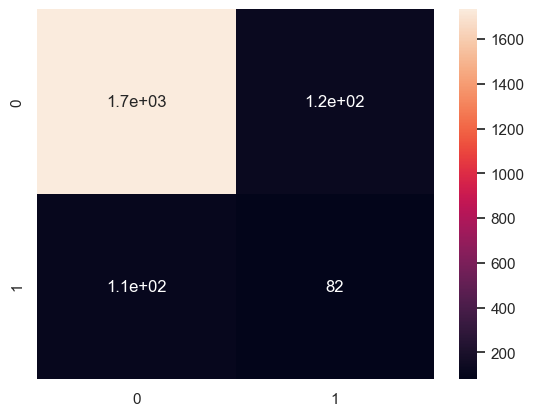

In [45]:
%%timeit -r 1 -n 1
# walmart amazon dirty dice
coeff_train_dice_4_1 = getCoeffDice(dirty_train4['text_left'], dirty_train4['text_right'])
real_train4_1 = toInt(dirty_train4['label'])
t_train_dice_4_1, f_train_dice_4_1 = token_threshold(coeff_train_dice_4_1, real_train4_1)
print('walmart amazon dirty dice')
print('threshold of the training set is:{}'.format(t_train_dice_4_1))
print('f1 score of training set is:{}'.format(f_train_dice_4_1))
coeff_test_dice_4_1 = getCoeffDice(dirty_test4['text_left'], dirty_test4['text_right'])
real_test4_1 = toInt(dirty_test4['label'])
pre_list_dice_4_1 = token_prediction(coeff_test_dice_4_1, t_train_dice_4_1)
pre_dice_4_1 = toInt(pre_list_dice_4_1)
f_test_dice_4_1 = f1_score(real_test4_1, pre_dice_4_1, average='binary')
print('f1 score of the testing set is:{}'.format(f_test_dice_4_1))
print(classification_report(real_test4_1, pre_dice_4_1))
sns.set()
C2= confusion_matrix(real_test4_1, pre_list_dice_4_1, labels=[0, 1])
print(C2)
sns.heatmap(C2,annot=True)